In [1]:
from gvuln import *

torch.set_default_dtype(torch.float32)

# Differential Privacy

### No DP

In [2]:
compiledFile=compile2SOGA('DP_nonoise.soga')
cfg = produce_cfg(compiledFile)

output_dist = start_SOGA(cfg)

marg_nonoise = extract_marginal(output_dist, ['dataset[0]', 'avg'])

vdelta_nonoise = vdelta_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=1)
vgauss_nonoise = vgauss_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], eps=1, idx_o=1)

gvd_nonoise = vdelta_nonoise.item()
gvg_nonoise = vgauss_nonoise.item()

gvd_nonoise, gvg_nonoise

(0.02102610468864441, 0.05263157933950424)

In [3]:
s_marg = extract_marginal(output_dist, ['dataset[0]'])
so_marg = extract_marginal(output_dist, ['dataset[0]', 'avg'])

entropy_nonoise = entropy_gaussian(s_marg.gm.mu[0], s_marg.gm.sigma[0])
cond_entropy_nonoise = cond_entropy_gaussian(so_marg.gm.mu[0], so_marg.gm.sigma[0], idx_o = [1])
mi_nonoise = mi_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=[1])

print('Entropy of secret: ', entropy_nonoise)
print('Entropy of secret given output: ', cond_entropy_nonoise)
print('MI between secret and output: ', mi_nonoise)

Entropy of secret:  tensor(4.4147)
Entropy of secret given output:  tensor(4.3620)
MI between secret and output:  0.05268049240112305


In [4]:
compiledFile=compile2SOGA('DP_nonoise_obs.soga')
cfg = produce_cfg(compiledFile)

output_dist_obs = start_SOGA(cfg)

s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

s_mu_obs = s_marg_obs.gm.mu[0]
s_sigma_obs = s_marg_obs.gm.sigma[0]
s_mu = s_marg.gm.mu[0]
s_sigma = s_marg.gm.sigma[0]

kl_nonoise = kl_div_gaussian(s_mu_obs, s_sigma_obs, s_mu, s_sigma)

print('KL divergenge between secret given output value and secret: ', kl_nonoise)


KL divergenge between secret given output value and secret:  0.007680241949856281


### Gaussian Mechanism

In [5]:
Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

gvd_gauss = {}   # g-vulnerability for delta gain
gvg_gauss = {}   # g-vulnerability for Gaussian gain
entropy_gauss = {}       # entropy of the secret variable
cond_entropy_gauss = {}  # conditional entropy of secret given output
mi_gauss = {}            # mutual information between secret and output
kl_gauss = {}        # KL divergence between secret given output value and secret 

for eps in eps_list:

    compiledFile=compile2SOGA('DP_Gauss.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta*torch.log(torch.tensor(1.25/delta))/(2*eps))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    output_dist = start_SOGA(cfg, params_dict=params_dict)

    marg_gauss = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    s_marg_gauss = extract_marginal(output_dist, ['dataset[0]'])

    entropy_gauss['{}'.format(eps)] = entropy_gaussian(s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])
    cond_entropy_gauss['{}'.format(eps)] = cond_entropy_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    mi_gauss['{}'.format(eps)] = mi_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    gvd_gauss['{}'.format(eps)] =  vdelta_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=1).item()
    gvg_gauss['{}'.format(eps)] = vgauss_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], eps=1, idx_o=1).item()

    compiledFile=compile2SOGA('DP_Gauss_obs.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta*torch.log(torch.tensor(1.25/delta))/(2*eps))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    s_marg_gauss_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

    kl_gauss['{}'.format(eps)] = kl_div_gaussian(s_marg_gauss_obs.gm.mu[0], s_marg_gauss_obs.gm.sigma[0], s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])
    

In [11]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, gvd_gauss[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, gvg_gauss[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, cond_entropy_gauss[key]))

print('\n Mutual Information   ')
for key in mi_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, mi_gauss[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.10000000149011612, exact=0.019999520853161812
	 Eps = 0.5, exact=0.02016650140285492
	 Eps = 1.0, exact=0.02031172439455986
	 Eps = 2.0, exact=0.020492125302553177
	 Eps = 5.0, exact=0.020722271874547005
	 Eps = 10.0, exact=0.020849281921982765

 G-Vulnerability (Gauss Gain)
	 Eps = 0.10000000149011612, exact=0.05006849020719528
	 Eps = 0.5, exact=0.050485461950302124
	 Eps = 1.0, exact=0.05084808170795441
	 Eps = 2.0, exact=0.051298510283231735
	 Eps = 5.0, exact=0.0518731027841568
	 Eps = 10.0, exact=0.05219017714262009

 Conditional Entropy   
	 Eps = 0.10000000149011612, exact=4.412046432495117
	 Eps = 0.5, exact=4.4037322998046875
	 Eps = 1.0, exact=4.396557331085205
	 Eps = 2.0, exact=4.387714385986328
	 Eps = 5.0, exact=4.3765459060668945
	 Eps = 10.0, exact=4.37043571472168

 Mutual Information   
	 Eps = 0.10000000149011612, exact=0.00262451171875
	 Eps = 0.5, exact=0.010938644409179688
	 Eps = 1.0, exact=0.01811361312866211
	 Eps = 2.0, 

### Laplacian Mechanism

In [ ]:
Delta = 150/10
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

gvd_lap_lb = {}
gvd_lap_ub = {}
gvg_lap_lb = {}
gvg_lap_ub = {}

gvd_lap = {}
gvg_lap = {}

cond_entropy_lap_lb = {}
cond_entropy_lap_ub = {}

mi_lap_lb = {}
mi_lap_ub = {}

kl_lap_lb = {}
kl_lap_ub = {}

for eps in eps_list:

    compiledFile=compile2SOGA('DP_Laplace.soga')
    cfg = produce_cfg(compiledFile)

    b = Delta/eps

    print(b)

    pi, mu1, mu2, sigma1, sigma2, _ = fit_laplace(torch.tensor(0.), b)

    pars = {'p1': pi,
            'p2': 1-pi,
            'mean1': mu1,
            'mean2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value, requires_grad=True)    

    output_dist = start_SOGA(cfg, params_dict=params_dict)

    marg_lap = extract_marginal(output_dist, ['dataset[0]', 'avg'])

    gvd_lap['{}'.format(eps)] = sample_gvuln(output_dist, 1000, gain_type='delta', secret_var='dataset[0]', output_var='avg')
    gvg_lap['{}'.format(eps)] = sample_gvuln(output_dist, 1000, gain_type='gauss', secret_var='dataset[0]', output_var='avg')

    gvd_lap_lb['{}'.format(eps)] = vdelta_lower_bound(marg_lap, idx_o=1)
    gvd_lap_ub['{}'.format(eps)] = vdelta_upper_bound(marg_lap, idx_o=1)
    gvg_lap_lb['{}'.format(eps)] = vgauss_lower_bound(marg_lap, 1., idx_o=1)
    gvg_lap_ub['{}'.format(eps)] = vgauss_upper_bound(marg_lap, 1., idx_o=1)

    cond_entropy_lap_lb['{}'.format(eps)] = cond_entropy_lb(marg_lap, idx_o=[1])
    cond_entropy_lap_ub['{}'.format(eps)] = cond_entropy_ub(marg_lap, idx_o=[1])
    
    mi_lap_lb['{}'.format(eps)] = mi_lb(marg_lap, idx_o=[1])
    mi_lap_ub['{}'.format(eps)] = mi_ub(marg_lap, idx_o=[1])


tensor(150.)
Step 0, KL: 0.0101
Step 100, KL: -0.0001
Step 200, KL: -0.0003
Step 300, KL: -0.0003
Step 400, KL: -0.0003
Step 500, KL: -0.0003
Step 600, KL: -0.0003
Step 700, KL: -0.0003
Step 800, KL: -0.0003
Step 900, KL: -0.0003
tensor(30.)
Step 0, KL: 0.0503
Step 100, KL: -0.0004
Step 200, KL: -0.0013
Step 300, KL: -0.0013
Step 400, KL: -0.0013
Step 500, KL: -0.0013
Step 600, KL: -0.0013
Step 700, KL: -0.0013
Step 800, KL: -0.0013
Step 900, KL: -0.0013
tensor(15.)
Step 0, KL: 0.1006
Step 100, KL: -0.0008
Step 200, KL: -0.0026
Step 300, KL: -0.0026
Step 400, KL: -0.0026
Step 500, KL: -0.0026
Step 600, KL: -0.0026
Step 700, KL: -0.0026
Step 800, KL: -0.0026
Step 900, KL: -0.0026
tensor(7.5000)
Step 0, KL: 0.2013
Step 100, KL: -0.0016
Step 200, KL: -0.0052
Step 300, KL: -0.0052
Step 400, KL: -0.0052
Step 500, KL: -0.0052
Step 600, KL: -0.0052
Step 700, KL: -0.0052
Step 800, KL: -0.0052
Step 900, KL: -0.0052
tensor(3.)
Step 0, KL: 0.5032
Step 100, KL: -0.0041
Step 200, KL: -0.0131
Step 3

In [13]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_lap_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, gvd_lap_lb[key], gvd_lap[key], gvg_lap_ub[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_lap_ub.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, gvg_lap_lb[key], gvg_lap[key], gvg_lap_ub[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_lap_ub.keys():
    print('\t Eps = {}, lb = {},ub= {}'.format(key, cond_entropy_lap_lb[key], cond_entropy_lap_ub[key]))

print('\n Mutual Information   ')
for key in mi_lap_ub.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, mi_lap_lb[key], mi_lap_ub[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.10000000149011612, lb = 0.0186472125351429, exact=0.019145777449011803, ub= 0.049940939992666245
	 Eps = 0.5, lb = 0.018677912652492523, exact=0.018875379115343094, ub= 0.050018154084682465
	 Eps = 1.0, lb = 0.01876283809542656, exact=0.01938682608306408, ub= 0.050231896340847015
	 Eps = 2.0, lb = 0.018992915749549866, exact=0.019840839318931103, ub= 0.05081280693411827
	 Eps = 5.0, lb = 0.01941869780421257, exact=0.02013232372701168, ub= 0.051910147070884705
	 Eps = 10.0, lb = 0.019583003595471382, exact=0.02022702619433403, ub= 0.05237647891044617

 G-Vulnerability (Gauss Gain)
	 Eps = 0.10000000149011612, lb = 0.04668330401182175, exact=0.04847714429100355, ub= 0.049940939992666245
	 Eps = 0.5, lb = 0.04675997421145439, exact=0.048314704249302544, ub= 0.050018154084682465
	 Eps = 1.0, lb = 0.046972040086984634, exact=0.049110482136408486, ub= 0.050231896340847015
	 Eps = 2.0, lb = 0.04754655063152313, exact=0.05017554573714733, ub= 0.0508128069

### Geometric Mechanism

In [2]:
# No Noise

compiledFile=compile2SOGA('DP_Geometric.soga')
cfg = produce_cfg(compiledFile)
dist = start_SOGA(cfg)

secret_var = 'dataset[0]'
output_var = 'count' 

discrete_V1(dist, secret_var, output_var)

tensor(0.6230)

In [3]:
eps_list = torch.tensor([0.25, 0.5, 1., 2., 5., 10.])

dict_discrete = {}

for eps in eps_list:

    Delta = torch.tensor(1.)
    p = 1 - torch.exp(-eps/Delta)

    gm_str = create_gm_from_p(p)

    program = '''array[10] dataset; 
                for i in range(10){{
                    dataset[i] = bern(0.5);
                }} end for;

                count = 0.0;
                for i in range(10){{
                    count = count + dataset[i];
                }} end for;

                geom1 = {};
                geom2 = {};
                noise = geom1 - geom2;

                count = count + noise;
                '''.format(gm_str, gm_str)

    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg)

    dict_discrete['{}'.format(eps)] = discrete_V1(output_dist, secret_var, output_var)



In [4]:
dict_discrete

{'0.25': tensor(0.5471),
 '0.5': tensor(0.5739),
 '1.0': tensor(0.6002),
 '2.0': tensor(0.6166),
 '5.0': tensor(0.6228),
 '10.0': tensor(0.6230)}

# Geo-indistinguishability

## Without Loops

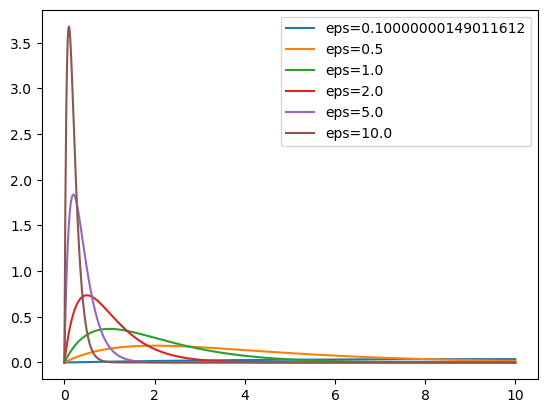

In [2]:
import matplotlib.pyplot as plt

mean = torch.tensor(2.)

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])
x = torch.linspace(0, 10, 1000)

for eps in eps_list:
    y = Gamma(mean, eps).log_prob(x).exp()
    plt.plot(x.numpy(), y.numpy(), label='eps={}'.format(eps.item()))
plt.legend()

In [ ]:
vdelta_lb = {}
vdelta_ub = {}
vgauss_lb = {}
vgauss_ub = {}
vdelta = {}
vgauss = {}

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

for eps in eps_list:

    print('Eps = {}'.format(eps))
        
    compiledFile=compile2SOGA('Geo_ind.soga')
    cfg = produce_cfg(compiledFile)

    mean = torch.tensor(2.)
    scale = 1/eps

    _, pi1, pi2, mu1, mu2, sigma1, sigma2 = fit_gamma(mean, scale)

    pars = {'p1': pi1,
            'p2': pi2,
            'mu1': mu1,
            'mu2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2
            }
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    output_dist = start_SOGA(cfg, params_dict=params_dict)
    marg_dist = extract_marginal(output_dist, ['x', 'y', 'xAnon', 'yAnon'])

    vdelta_lb['{}'.format(eps)] = vdelta_lower_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vdelta_ub['{}'.format(eps)] = vdelta_upper_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vgauss_lb['{}'.format(eps)] = vgauss_lower_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    vgauss_ub['{}'.format(eps)] = vgauss_upper_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    vdelta['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=5000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='delta')
    vgauss['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=1000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='gauss')


Eps = 0.10000000149011612
Eps = 0.5
Eps = 1.0
Eps = 2.0
Eps = 5.0


In [5]:
print('Delta Gain')
for key in vdelta_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, vdelta_lb[key], vdelta[key], vdelta_ub[key]))

print('\n Gauss Gain')
for key in vdelta_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, vgauss_lb[key], vgauss[key], vgauss_ub[key]))
    

Delta Gain
	 Eps = 0.10000000149011612, lb = 8.467446605209261e-05, exact=0.0005229097441770136, ub= 0.0012272068997845054
	 Eps = 0.5, lb = 0.004544512368738651, exact=0.02676321566104889, ub= 0.0363597609102726
	 Eps = 1.0, lb = 0.01866469904780388, exact=0.09883255884051323, ub= 0.18039727210998535
	 Eps = 2.0, lb = 0.1003422662615776, exact=0.5379543304443359, ub= 0.8060247302055359
	 Eps = 5.0, lb = 0.458886981010437, exact=1.3103138208389282, ub= 3.6710972785949707

 Gauss Gain
	 Eps = 0.10000000149011612, lb = 0.0005111823556944728, exact=0.0034614040050655603, ub= 0.007530051749199629
	 Eps = 0.5, lb = 0.023198803886771202, exact=0.14509349316358566, ub= 0.18561336398124695
	 Eps = 1.0, lb = 0.03625297546386719, exact=0.3266650289297104, ub= 0.4351688623428345
	 Eps = 2.0, lb = 0.08273743093013763, exact=0.6356545090675354, ub= 0.6807507276535034
	 Eps = 5.0, lb = 0.1186552420258522, exact=0.9412767291069031, ub= 0.9492512345314026


In [121]:
from torch.distributions import Uniform

def orig_geo(n_samples=1000, scale=1.):
    x = Uniform(-90, 90).sample((n_samples,))
    y = Uniform(-180, 180).sample((n_samples,))
    r = Gamma(2., 1./scale).sample((n_samples,))
    theta = Uniform(0, 2*torch.pi).sample((n_samples,))
    x_anon = x + r * torch.cos(theta)
    y_anon = y + r * torch.sin(theta)
    return x_anon, y_anon

n_samples = 10_000_000

x_anon, y_anon = orig_geo(n_samples=n_samples, scale=1.)
torch.mean(x_anon), torch.mean(y_anon), torch.std(x_anon), torch.std(y_anon)

(tensor(-0.0074), tensor(0.0275), tensor(51.9973), tensor(103.9495))

## With Loops

In [11]:
from torch.distributions import Uniform

In [96]:
def von_neumann_exponential():
    K = 0
    while True:
        x = Uniform(0,1).sample()
        x1 = x
        x_next = Uniform(0,1).sample()
        n = 1
        while x > x_next:
            x = x_next
            x_next = Uniform(0,1).sample()
            if n == 0:
                n = 1
            elif n == 1:
                n = 0
        if n == 1:
            return K + x1
        else:
            K = K + 1


#def von_neumann_exponential():
#    K = 0
#    while True:
#        n = 0
#        x = Uniform(0,1).sample()
#        x_next = Uniform(0,1).sample()
#        while x <= x_next:
#            x = x_next
#            x_next = Uniform(0,1).sample()
#            if n == 0:
#                n = 1
#            elif n == 1:
#                n = 0
#        if n == 0:
#            x1 = Uniform(0,1).sample()
#            return K + x1
#        else:
#            K = K + 1

def rejection_sampling():
    while True:
        w = Uniform(0,20).sample()
        u = Uniform(0,1).sample()
        if u <= torch.exp(-w):
            return w


def gamma_sampling(mean, scale):
    sum_exps = torch.tensor(0.)
    for _ in range(mean):
        sum_exps += von_neumann_exponential()
    return sum_exps / scale

mean = torch.tensor(2)
scale = torch.tensor(1.0)

samples = []
for i in range(10000):
    samples.append(gamma_sampling(mean, scale))

# exp_samples = []
#for i in range(1000):
#    exp_samples.append(von_neumann_exponential())


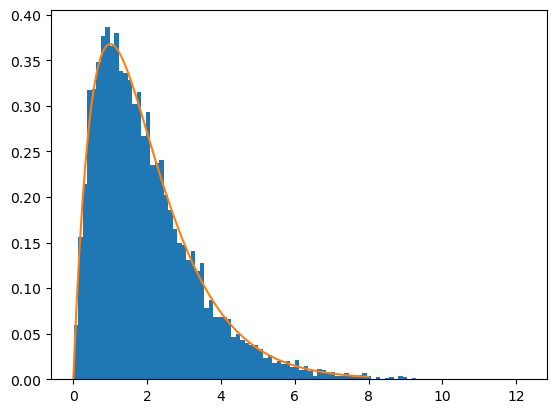

In [97]:
x = torch.linspace(0, 8, 100)
y = torch.distributions.Gamma(mean, 1/scale).log_prob(x).exp()

_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(x.numpy(), y.numpy())

In [98]:
samples = torch.hstack(samples)
torch.mean(samples), mean*scale

(tensor(1.9911), tensor(2.))